In [1]:
import sys
# Import NDVM modules to load pickled data
# NOTE: Modify based on your environment
sys.path.append('/home/dosoukup/Dataset/drift-katoda-v2/katoda-tools/ndvm/modules')
sys.path.append('/home/dosoukup/Dataset/drift-katoda-v2/katoda-tools/ndvm')
import os
import pickle
import metric1, metric3, metric2x
import json
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import pandas as pd

In [2]:
# NOTE: Modify based on your report. By default it is enough to change the id number
REPORT_NAME = "metrics/report-dataset-1767185942"

# General Report 

In [3]:
with open(REPORT_NAME+'.csv', 'r') as file:
    basic = json.load(file)
pprint(basic)

{'Analyzed Samples': {'0': 29,
                      '1': 504,
                      '10': 68,
                      '100': 79,
                      '101': 99,
                      '102': 182,
                      '103': 192,
                      '104': 1115,
                      '105': 172,
                      '106': 2741,
                      '107': 169,
                      '108': 162,
                      '109': 124,
                      '11': 74,
                      '110': 2322,
                      '111': 103,
                      '112': 1685,
                      '113': 198,
                      '114': 177,
                      '115': 182,
                      '116': 2236,
                      '117': 402,
                      '118': 1302,
                      '119': 833,
                      '12': 115,
                      '120': 2104,
                      '121': 402,
                      '122': 140,
                      '123': 914,
                   

# Metric 1

In [4]:
with open(REPORT_NAME+"-metric1/metric1.obj", "rb") as f:
    metric1 = pickle.load(f)

In [5]:
metric1.ds_redundancy

0.1796875

In [6]:
data = metric1.redundancy_metadata

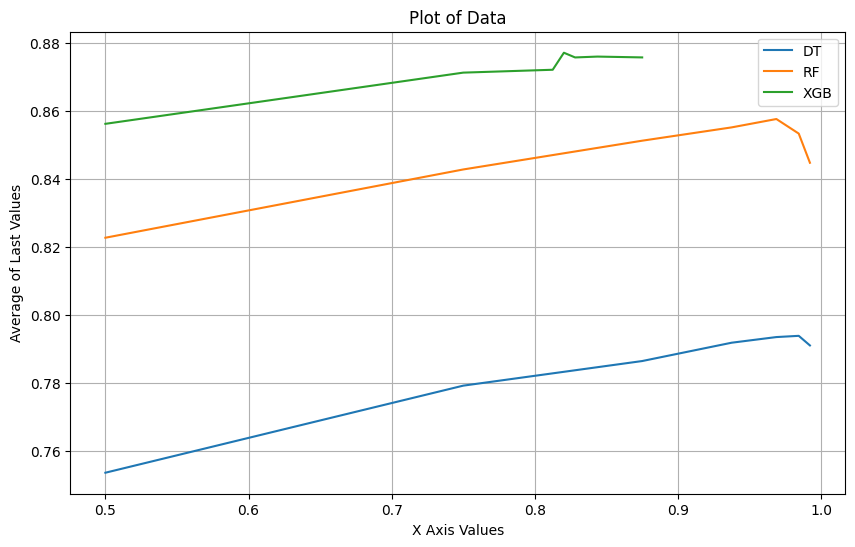

In [7]:
plt.figure(figsize=(10, 6))

for item in data:
    for name, values in item.items():
        x_values = sorted(values.keys())
        y_values = []
        for x in x_values:
            # Calculate the average of the last values (assuming each list has 5 values)
            avg_y = np.mean([v[0] for v in values[x]])
            y_values.append(avg_y)
        plt.plot(x_values, y_values, label=name)

plt.xlabel("X Axis Values")
plt.ylabel("Average of Last Values")
plt.title("Plot of Data")
plt.legend()
plt.grid(True)
plt.show()

# Metric 2x

In [8]:
# Load the Pickled Metric Object
try:
    pickle_path = os.path.join(f'{REPORT_NAME}-metric2', 'metric2x.obj')
    with open(pickle_path, 'rb') as f:
        metric2_obj = pickle.load(f)
    print("✅ Successfully loaded pickled metric2 object!")
    print(f"   - Classifiers used: {list(metric2_obj.classifiers.keys())}")
    print(f"   - Permutation percentages: {metric2_obj.permutation_percentages}")
    
except FileNotFoundError:
    print(f"❌ Error: Could not find the pickle file at {pickle_path}")
except Exception as e:
    print(f"❌ An error occurred while loading the pickle file: {e}")

✅ Successfully loaded pickled metric2 object!
   - Classifiers used: ['DT', 'RF', 'XGB']
   - Permutation percentages: [50, 30, 10, 1]


In [9]:
final_scores = metric2_obj.get_score()

In [10]:
# Display P-Values and Final Scores

print("="*30)
print("      P-Value Table")
print("="*30)

# Create a clean pandas DataFrame for the p-values
p_value_df = pd.DataFrame(
    data=metric2_obj.p_values,
    index=metric2_obj.classifiers.keys(),
    columns=metric2_obj.permutation_percentages
)
print(p_value_df)

print("\n" + "="*30)
print("      Final Score Summary")
print("="*30)

# The final results are already calculated and stored in the object
final_scores = metric2_obj.get_score()
for key, value in final_scores.items():
    if key != "P-value table":
        print(f"{key+':':<20} {value}")

      P-Value Table
           50        30        10        1 
DT   0.009901  0.009901  0.009901  0.009901
RF   0.009901  0.009901  0.009901  0.009901
XGB  0.009901  0.009901  0.009901  0.009901

      Final Score Summary
Association:         0.6731639121419686
Max Clf Score:       0.7914038260485151
Raw Slope:           1.0101 (XGB)
Raw AUC:             0.2609 (XGB)
P-value status:      Good


Generating plot for individual permutation runs with polyfit trend line...


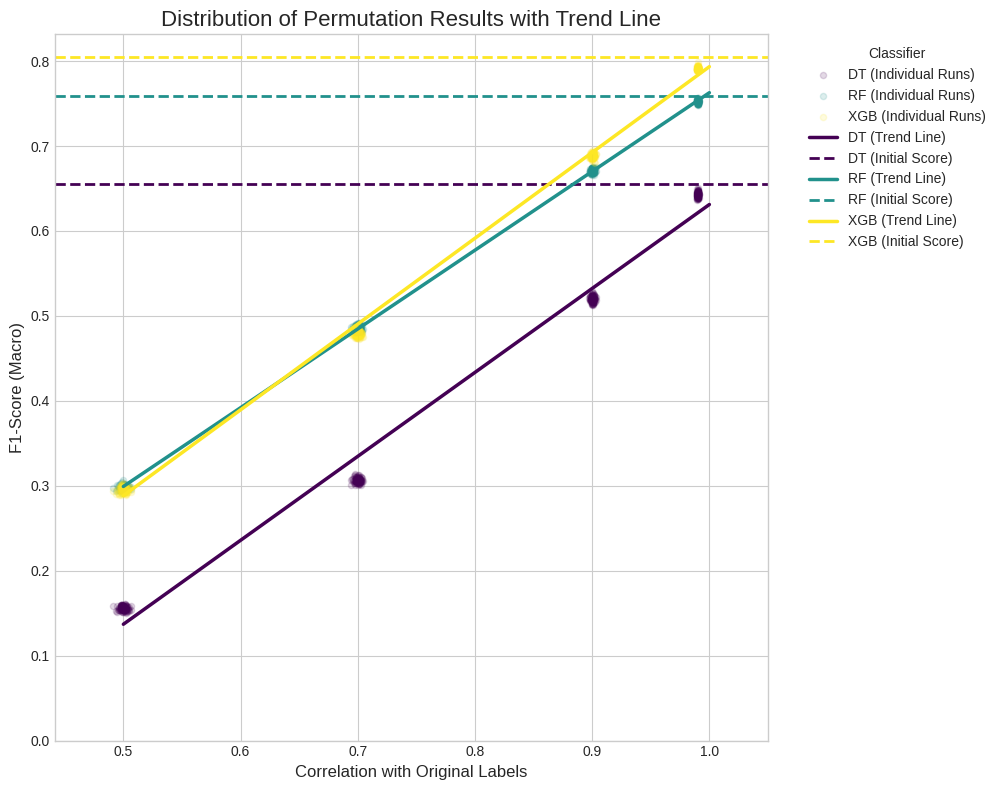

In [11]:
# Visualize Individual Permutations with Polyfit Trend Line 

print("Generating plot for individual permutation runs with polyfit trend line...")

# Extract data from the loaded object
classifier_names = list(metric2_obj.classifiers.keys())
num_classifiers = len(classifier_names)
initial_scores = metric2_obj.initial_scores[0] # This is a 1D array of the initial scores

# Prepare the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))
colors = cm.viridis(np.linspace(0, 1, num_classifiers))

# Get the mean correlations (X-axis for the polyfit)
mean_correlations = metric2_obj.correlations.mean(axis=0)

# --- Plotting each individual permutation run as a scatter point ---
for i, (name, color) in enumerate(zip(classifier_names, colors)):
    # Flatten the arrays to get a list of all correlation scores and corresponding F1-scores
    all_correlations = metric2_obj.correlations.flatten()
    all_scores_for_clf = metric2_obj.permuted_scores[:, :, i].flatten()
    
    # Use a low alpha to see point density
    ax.scatter(all_correlations, all_scores_for_clf, color=color, alpha=0.15, s=20, label=f'{name} (Individual Runs)')

# --- Overlay the polyfit trend lines and the initial score line ---
for i, (name, color) in enumerate(zip(classifier_names, colors)):
    
    # Get the mean scores for this classifier (Y-axis for the polyfit)
    mean_scores = metric2_obj.permuted_scores[:, :, i].mean(axis=0)
    
    # Calculate the polyfit line (degree 1) exactly as the module does
    slope, intercept = np.polyfit(mean_correlations, mean_scores, 1)
    
    # Create X-values for plotting the line (from lowest mean correlation to 1.0)
    x_line = np.array([np.min(mean_correlations), 1.0])
    
    # Calculate the corresponding Y-values for the line
    y_line = slope * x_line + intercept
    
    # Plot the polyfit trend line
    ax.plot(x_line, y_line, linestyle='-', color=color, linewidth=2.5, label=f'{name} (Trend Line)')
    # -----------------------------------------------------------------
    
    # --- Draw the horizontal line for the initial, non-permuted score ---
    initial_score = initial_scores[i]
    ax.axhline(y=initial_score, color=color, linestyle='--', linewidth=2, label=f'{name} (Initial Score)')
    # -------------------------------------------------------------------

# --- Formatting and Finalizing the Plot ---

# Create a clean legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), title='Classifier', bbox_to_anchor=(1.04, 1), loc='upper left')

ax.set_title('Distribution of Permutation Results with Trend Line', fontsize=16)
ax.set_xlabel('Correlation with Original Labels', fontsize=12)
ax.set_ylabel('F1-Score (Macro)', fontsize=12)
ax.set_ylim(bottom=0)
ax.set_xlim(left=min(metric2_obj.correlations.flatten()) - 0.05, right=1.05)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1]) # rect=[left, bottom, right, top]
plt.show()

# Metric 3

In [12]:
with open(REPORT_NAME+"-metric3/metric3.obj", "rb") as f:
    metric3 = pickle.load(f)

In [13]:
# The base key
next(iter(basic["Similarity"]["detail"]))

'87'

In [14]:
# All keys
basic["Similarity"]["detail"].keys()

dict_keys(['87', '104', '138', '35', '15', '85', '74', '52', '70', '142', '2', '136', '86', '91', '54', '129', '44', '38', '116', '51', '118', '113', '81', '139', '110', '106', '88', '119', '125', '63', '34', '18', '78', '23', '48', '71', '28', '16', '83', '157', '112', '77', '108', '103', '49', '80', '97', '105', '55', '53', '98', '120', '41', '65', '123', '76', '46', '60', '84', '128', '26', '73', '1', '140', '141', '134', '27', '127', '132', '5', '93', '69', '42', '13', '43', '90', '36', '24', '101', '17', '111', '21', '89', '148', '22', '147', '144', '40', '6', '117', '153', '146', '59', '154', '92', '130', '67', '96', '114', '75', '82', '122', '20', '32', '102', '31', '149', '94', '158', '135', '4', '25', '99', '64', '150', '29', '95', '57', '72', '133', '121', '109', '131', '61', '12', '8', '66', '58', '37', '155', '10', '39', '115', '56', '45', '137', '9', '156', '14', '100', '68', '47', '50', '107', '126', '7', '151', '145', '152', '33', '124', '143', '19', '159', '11', '3', '0

In [15]:
# All metric 3 metadata
basic["Similarity"]["detail"]

{'87': {'l1_loss': 0.061981771141290665, 'relative_loss': 1.3825830207278949},
 '104': {'l1_loss': 0.08814559131860733, 'relative_loss': 1.9662006371408915},
 '138': {'l1_loss': 0.08133989572525024, 'relative_loss': 1.8143908550330383},
 '35': {'l1_loss': 0.06781167536973953, 'relative_loss': 1.512626523040038},
 '15': {'l1_loss': 0.08213353902101517, 'relative_loss': 1.8320940881777932},
 '85': {'l1_loss': 0.09192674607038498, 'relative_loss': 2.050544150762589},
 '74': {'l1_loss': 0.07077877968549728, 'relative_loss': 1.5788115960406754},
 '52': {'l1_loss': 0.04483041539788246, 'relative_loss': 1.0},
 '70': {'l1_loss': 0.07036025077104568, 'relative_loss': 1.5694757710045468},
 '142': {'l1_loss': 0.0844736099243164, 'relative_loss': 1.8842923754908252},
 '2': {'l1_loss': 0.06692669540643692, 'relative_loss': 1.4928859082041466},
 '136': {'l1_loss': 0.09042347222566605, 'relative_loss': 2.017011696704848},
 '86': {'l1_loss': 0.07584545761346817, 'relative_loss': 1.6918303553584892},
 